#Задача «Классификация агрокультур на основе изменения показателя вегетационных индексов во временной последовательности»

##Условие задачи

Перед участниками чемпионата стоит
задача
классификации
агрокультур на основе изменения показателя вегетационных индексов во
временной последовательности. Созданная за время чемпионата модель
поможет оптимизировать рабочие процессы в сфере сельского хозяйства,
обеспечить
органы
власти
актуальными
и
достоверными
сведениями,
увеличить социальный, инвестиционный и производственный потенциал
отрасли,
а
также
повысить
достоверность
и
удобство использования
информации о сельскохозяйственных объектах.

###Описание входных значений
● train.csv — файл, содержащий данные о поле и временные ряды

● test.csv — файл, содержащий данные для предсказания

● sample_solution.csv — пример файла для отправки

**Пояснения к столбцам**



*   id – идентификатор объекта (поля)
*   area – площадь поля в га
*   nd mean YYYY-MM-DD – медианное значение вегетационного индекса
NDVI для данного поля на указанную дату
*   geo – координаты границ поля
*   crop – столбец для предсказания, содержит тип произрастающей
культуры по данным сельхозтоваропроизводителей

**Дополнительно расшифруем типы культур:**

0.   подсолнечник
1.   картофель
2.   пшеница озимая
3.   гречиха
4.   кукуруза
5.   пшеница яровая
6.   сахарная свекла


In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# импорт библиотек
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline

from sklearn import svm
import xgboost as xgb
import pylab as pl

from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

import warnings
from warnings import filterwarnings
warnings.filterwarnings('error')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
%matplotlib inline

RANDOM_STATE = 12345

In [3]:
# загрузка датасетов
df_train = pd.read_csv("/content/train_dataset_train.csv")
df_test = pd.read_csv("/content/test_dataset_test.csv")

In [4]:
# функция на первичную проверку данных
def df_check(dataset):
    print('Общая информация\n')
    display(dataset.info())
    print('Первые строки датасета\n')
    display(dataset.head())
    print('Описательная статистика\n')
    display(dataset.describe())
    print('Описательная статистика столбцов object\n')
    display(dataset.describe(include=['object', 'bool']))
    print('Количество пропусков в каждом столбце\n')
    display(dataset.isna().sum())
    print('Количество уникальных значений\n')
    display(dataset.nunique())
    print('Количество дубликатов\n')
    display(dataset.duplicated().sum())

In [5]:
df_check(df_train)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   int64  
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   f

None

Первые строки датасета



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,...,0.108999,0.118854,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498,3
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,...,0.134469,0.208268,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997,4
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,...,0.084467,0.000000,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2
3,2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,...,0.000000,0.642226,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523,5
4,3685,33,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,...,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,4


Описательная статистика



,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,...,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000
mean,3473.406211,53.871429,0.149911,0.118843,0.158939,0.166146,0.125002,0.162440,0.092302,0.108834,...,0.153016,0.168406,0.111583,0.141471,0.172343,0.121483,0.145211,0.107207,0.119274,2.953830
std,1984.993812,34.191660,0.112598,0.103192,0.136001,0.123605,0.117605,0.145027,0.095207,0.120939,...,0.185321,0.219428,0.150879,0.190674,0.228629,0.151392,0.162711,0.108508,0.155346,2.004587
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.005158,-0.000653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1772.500000,26.000000,0.047477,0.025280,0.050124,0.053859,0.027609,0.040885,0.012844,0.014682,...,0.020299,0.020892,0.012363,0.017028,0.018379,0.015292,0.022416,0.017028,0.011673,1.000000
50%,3489.500000,45.000000,0.142240,0.097346,0.129819,0.155571,0.096516,0.121307,0.069936,0.077155,...,0.086570,0.086574,0.068423,0.077626,0.085643,0.076428,0.088429,0.079537,0.070808,3.000000
75%,5191.750000,76.000000,0.245596,0.202955,0.241323,0.269131,0.192070,0.277772,0.143207,0.162079,...,0.189195,0.190436,0.149199,0.168154,0.192834,0.162134,0.198258,0.162584,0.158424,5.000000
max,6900.000000,140.000000,0.987671,0.760245,0.764437,0.983779,0.668150,0.970286,0.779277,0.782066,...,0.835639,0.892481,0.867968,0.946030,0.939444,0.896011,0.786905,0.766119,0.835383,6.000000


Описательная статистика столбцов object



,.geo
count,4830
unique,4830
top,"{""type"":""Polygon"",""coordinates"":[[[42.49107269..."
freq,1


Количество пропусков в каждом столбце



id                    0
area                  0
nd_mean_2021-04-16    0
nd_mean_2021-04-19    0
nd_mean_2021-04-22    0
                     ..
nd_mean_2021-08-13    0
nd_mean_2021-08-27    0
nd_mean_2021-05-08    0
nd_mean_2021-05-24    0
crop                  0
Length: 74, dtype: int64

Количество уникальных значений



id                    4830
area                   131
nd_mean_2021-04-16    4272
nd_mean_2021-04-19    4081
nd_mean_2021-04-22    4298
                      ... 
nd_mean_2021-08-13    3939
nd_mean_2021-08-27    4054
nd_mean_2021-05-08    4002
nd_mean_2021-05-24    3899
crop                     7
Length: 74, dtype: int64

Количество дубликатов



0

Сейчас разберу целевой столбец. Популярность культур и зависимость этого столбца от других данных.

In [6]:
df_train['crop'].value_counts().sort_index(ascending=True)

0    726
1    700
2    697
3    655
4    718
5    668
6    666
Name: crop, dtype: int64

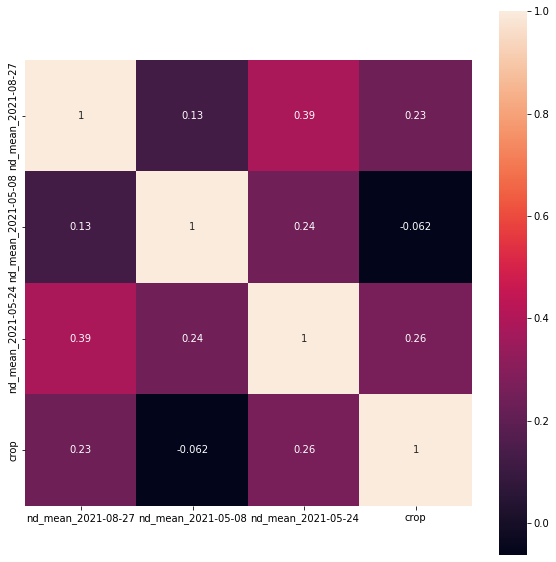

In [7]:
plt.rcParams['figure.figsize']=(10,10)

corr = df_train.loc[:, "nd_mean_2021-08-27":"crop"].corr()
g = sns.heatmap(corr, square = True, annot=True)

In [8]:
time_nd_mean = df_train.loc[:, 'nd_mean_2021-04-16':'nd_mean_2021-05-24':]
time_nd_mean

,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,nd_mean_2021-05-17,...,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
0,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,0.484102,0.201013,...,0.425571,0.108999,0.118854,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498
1,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,0.519456,0.501486,...,0.248935,0.134469,0.208268,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997
2,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,0.000000,0.561541,...,0.127633,0.084467,0.000000,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614
3,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,0.510271,0.511552,...,0.527583,0.000000,0.642226,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523
4,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,0.000000,0.403379,...,0.000000,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,0.028770,0.038282,0.255329,0.148166,0.225421,0.479483,0.071684,0.016856,0.407955,0.367435,...,0.169733,0.001875,0.031995,0.066882,0.139222,0.009041,0.042483,0.022464,0.017705,0.148440
4826,0.035939,0.030722,0.033869,0.029646,0.318387,0.247905,0.265180,0.286298,0.578936,0.420588,...,0.041057,0.192014,0.255964,0.131357,0.000000,0.187236,0.055721,0.044182,0.048316,0.041440
4827,0.191255,0.063581,0.140111,0.323984,0.000000,0.005056,0.092693,0.399439,0.006256,0.477546,...,0.022025,0.085006,0.187352,0.142930,0.000000,0.047572,0.007225,0.145505,0.051215,0.079730
4828,0.291399,0.221428,0.007247,0.055074,0.057781,0.187749,0.112403,0.183555,0.504538,0.721011,...,0.490711,0.536825,0.644357,0.085861,0.631304,0.694524,0.031836,0.453151,0.000000,0.006495


Явных зависимостей не выявлено. Приступлю к замене значений временных рядов у которых есть пропуски и они заменены нулями.

In [9]:
df_new_train = df_train.copy()

Пропуски заполнены нулевыми значениями, так же есть отрицательные значения, хотя диапазон nd mean от 0 до 1.

In [10]:
df_new_train = df_new_train.drop(['.geo'], axis = 1) 

In [11]:
df_new = df_new_train.copy()

In [12]:
# все отрицательные и нулевые значения заменю на NaN
cols = ['nd_mean_2021-04-16', 'nd_mean_2021-04-19', 'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
         'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07', 'nd_mean_2021-05-16', 'nd_mean_2021-05-17',
         'nd_mean_2021-05-21', 'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29', 'nd_mean_2021-06-06',
         'nd_mean_2021-06-13', 'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19', 'nd_mean_2021-06-20',
          'nd_mean_2021-06-22', 'nd_mean_2021-06-25', 'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
          'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15', 'nd_mean_2021-07-17', 'nd_mean_2021-07-20',
          'nd_mean_2021-07-26', 'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-07', 
          'nd_mean_2021-08-12', 'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25', 'nd_mean_2021-04-27',
          'nd_mean_2021-04-29', 'nd_mean_2021-04-30', 'nd_mean_2021-06-07', 'nd_mean_2021-06-12', 'nd_mean_2021-06-28',
          'nd_mean_2021-08-01', 'nd_mean_2021-08-11', 'nd_mean_2021-05-01', 'nd_mean_2021-05-03', 'nd_mean_2021-05-10', 
          'nd_mean_2021-05-15', 'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-07-04', 'nd_mean_2021-08-10',
          'nd_mean_2021-08-23', 'nd_mean_2021-04-20', 'nd_mean_2021-04-23', 'nd_mean_2021-05-09', 'nd_mean_2021-05-19',
          'nd_mean_2021-05-20', 'nd_mean_2021-06-04', 'nd_mean_2021-06-05', 'nd_mean_2021-06-10', 'nd_mean_2021-07-05',
          'nd_mean_2021-08-13',  'nd_mean_2021-08-27', 'nd_mean_2021-05-08', 'nd_mean_2021-05-24']
df_new[df_new[cols] <= 0] = np.nan

In [13]:
df_new_train['crop'].value_counts().sort_index(ascending=True)

0    726
1    700
2    697
3    655
4    718
5    668
6    666
Name: crop, dtype: int64

In [14]:
# все наны преобразую в среднее значение через импутер
imputer = IterativeImputer()
imputer.fit(df_new) 
X1 = imputer.transform(df_new)
df_new = pd.DataFrame(X1, columns = df_new_train.columns)

In [15]:
# все наны преобразую через K ближайших соседей
#imputer = KNNImputer(n_neighbors = 20)
#imputer.fit(df_new)
#X1 = imputer.transform(df_new)
#df_new = pd.DataFrame(X1, columns = df_new_train.columns)

In [16]:
df_new['crop'].value_counts().sort_index(ascending=True)

0.0    726
1.0    700
2.0    697
3.0    655
4.0    718
5.0    668
6.0    666
Name: crop, dtype: int64

In [17]:
df_new[['id', 'area', 'crop']] = df_new[['id', 'area', 'crop']].astype('int')

In [18]:
df_new['crop'].value_counts().sort_index(ascending=True)

0    726
1    700
2    697
3    655
4    718
5    668
6    666
Name: crop, dtype: int64

In [19]:
# все наны преобразую в среднее значение
#for i in df_new_train.columns[df_new_train.isnull().any(axis=0)]:
    #df_new_train[i].fillna(df_new_train[i].mean(),inplace=True)

In [20]:
# проверю что с моим датасетом
df_new.describe()

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
count,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,...,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000
mean,3473.406211,53.871429,0.164926,0.138131,0.173604,0.181630,0.142733,0.179549,0.113668,0.131564,...,0.172476,0.190248,0.133485,0.164381,0.196036,0.142017,0.164065,0.127875,0.141793,2.953830
std,1984.993812,34.191660,0.100472,0.091106,0.126543,0.111836,0.107424,0.134234,0.084533,0.111020,...,0.176211,0.212168,0.143569,0.183305,0.221048,0.142602,0.152884,0.098328,0.147640,2.004587
min,0.000000,10.000000,0.000441,0.000222,0.000527,0.000390,0.000354,-0.001791,0.000284,-0.015528,...,-0.026922,-0.149004,-0.018082,-0.049244,-0.107106,-0.021223,-0.023239,0.000126,-0.035420,0.000000
25%,1772.500000,26.000000,0.085290,0.065610,0.076857,0.090078,0.062387,0.072057,0.055019,0.054941,...,0.058339,0.054602,0.050452,0.051679,0.054143,0.053406,0.059805,0.057131,0.049943,1.000000
50%,3489.500000,45.000000,0.154406,0.122968,0.146286,0.173204,0.118203,0.146975,0.102205,0.109046,...,0.110862,0.114653,0.100161,0.106250,0.115424,0.104370,0.113970,0.107762,0.102969,3.000000
75%,5191.750000,76.000000,0.245905,0.204302,0.243581,0.269444,0.197169,0.278651,0.148057,0.172841,...,0.196110,0.203171,0.161157,0.185985,0.212357,0.170191,0.202608,0.169849,0.170197,5.000000
max,6900.000000,140.000000,0.987671,0.760245,0.764437,0.983779,0.668150,0.970286,0.779277,0.782066,...,0.835639,0.892481,0.867968,0.946030,0.939444,0.896011,0.786905,0.766119,0.835383,6.000000


In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 73 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   int64  
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   float64
 16  nd_mea

NaN заменены, пропусков нет, нулевых значений тоже. Явной зависимости целевого признака не обнаружено.

In [22]:
df_new['crop'].value_counts()

0    726
4    718
1    700
2    697
5    668
6    666
3    655
Name: crop, dtype: int64

## Обучение модели

В качестве признаков буду использовать nd_mean по времени и площадь, а в качестве цели предсказания будет crop - засеянная культура.

In [23]:
X = df_new.drop(['crop'], axis = 1)
y = df_new[['crop']]

In [24]:
# разделю данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3381, 72) (1449, 72)
(3381, 1) (1449, 1)


In [25]:
y.value_counts()

crop
0       726
4       718
1       700
2       697
5       668
6       666
3       655
dtype: int64

In [26]:
# стандартизация данных
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [27]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
model_knc = KNeighborsClassifier()
model_lr = LogisticRegression(verbose=1, n_jobs=-1, random_state=RANDOM_STATE) 
model_svc = svm.SVC(random_state=RANDOM_STATE)
model_HGBGT = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
model_LGBM = LGBMClassifier(objective = 'multiclass', num_class = 7, random_state=RANDOM_STATE)
model_xgb_cl = xgb.XGBClassifier()
model_cb = cb.CatBoostClassifier()

In [28]:
%%time
model_rfc.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_rfc = model_rfc.predict(X_test_scaled)

model_knc.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_knc = model_knc.predict(X_test_scaled)

model_lr.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_lr = model_lr.predict(X_test_scaled)

model_svc.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_svc = model_svc.predict(X_test_scaled)

model_HGBGT.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_HGBGT = model_HGBGT.predict(X_test_scaled)

model_LGBM.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_LGBM = model_LGBM.predict(X_test_scaled)

model_xgb_cl.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_xgb_cl = model_xgb_cl.predict(X_test_scaled)

model_cb.fit(X_train_scaled, np.ravel(y_train, order='C'))
pred_cb = model_cb.predict(X_test_scaled)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Learning rate set to 0.084199
0:	learn: 1.7506815	total: 170ms	remaining: 2m 49s
1:	learn: 1.5951570	total: 265ms	remaining: 2m 12s
2:	learn: 1.4609037	total: 356ms	remaining: 1m 58s
3:	learn: 1.3599108	total: 448ms	remaining: 1m 51s
4:	learn: 1.2720871	total: 544ms	remaining: 1m 48s
5:	learn: 1.1938638	total: 635ms	remaining: 1m 45s
6:	learn: 1.1213183	total: 730ms	remaining: 1m 43s
7:	learn: 1.0604790	total: 833ms	remaining: 1m 43s
8:	learn: 1.0100262	total: 933ms	remaining: 1m 42s
9:	learn: 0.9663369	total: 1.02s	remaining: 1m 41s
10:	learn: 0.9228431	total: 1.12s	remaining: 1m 40s
11:	learn: 0.8822633	total: 1.21s	remaining: 1m 39s
12:	learn: 0.8457219	total: 1.31s	remaining: 1m 39s
13:	learn: 0.8094362	total: 1.41s	remaining: 1m 39s
14:	learn: 0.7779001	total: 1.5s	remaining: 1m 38s
15:	learn: 0.7489365	total: 1.6s	remaining: 1m 38s
16:	learn: 0.7228728	total: 1.69s	remaining: 1m 37s
17:	learn: 0.6975002	total: 1.78s	remaining: 1m 37s
18:	learn: 0.6752801	total: 1.88s	remaining: 1

In [29]:
print(model_rfc,'\n', recall_score(y_test, pred_rfc, average="macro", zero_division=0))
print(model_knc,'\n', recall_score(y_test, pred_knc, average="macro", zero_division=0))
print(model_lr,'\n', recall_score(y_test, pred_lr, average="macro", zero_division=0))
print(model_svc,'\n', recall_score(y_test, pred_svc, average="macro", zero_division=0))
print(model_HGBGT,'\n', recall_score(y_test, pred_HGBGT, average="macro", zero_division=0))
print(model_LGBM,'\n', recall_score(y_test, pred_LGBM, average="macro", zero_division=0))
print(model_xgb_cl,'\n', recall_score(y_test, pred_xgb_cl, average="macro", zero_division=0))
print(model_cb,'\n', recall_score(y_test, pred_cb, average="macro", zero_division=0))

RandomForestClassifier(random_state=12345) 
 0.9483027602582579
KNeighborsClassifier() 
 0.9244628724123111
LogisticRegression(n_jobs=-1, random_state=12345, verbose=1) 
 0.9409487625634936
SVC(random_state=12345) 
 0.9585673128745793
HistGradientBoostingClassifier(random_state=12345) 
 0.9571362203239632
LGBMClassifier(num_class=7, objective='multiclass', random_state=12345) 
 0.9572573849822543
XGBClassifier(objective='multi:softprob') 
 0.9535861942956105
 0.9580341156459495


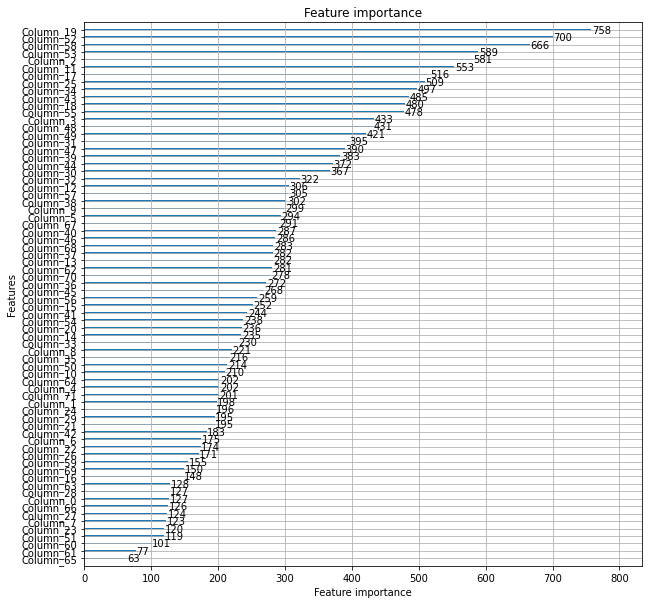

In [30]:
plot_importance(model_LGBM)
plt.show()

У трёх моделей буду подкручивать гиперпараметры: SVC, LGBMClassifier, CatBoostClassifier

#### SVC + gridsearch


In [31]:
#param_grid = {"C": [0.1, 1, 10, 100, 500], 
              #"gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              #"kernel": ["rbf"]}
#grid_model_svc = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
#grid_model_svc.fit(X_train_scaled, np.ravel(y_train, order='C'))

In [32]:
#print(grid_model_svc.best_params_)
#print(grid_model_svc.best_estimator_)

#pred_svc_grid = grid_model_svc.predict(X_test_scaled)
#print(grid_model_svc,'\n', recall_score(y_test, pred_svc_grid, average="macro", zero_division=0))

In [33]:
#model_svc_best_param = grid_model_svc.best_params_
#model_svc_best_param

In [34]:
#model_svc_best = svm.SVC(C= 1, gamma = 0.01, kernel = 'rbf', random_state=RANDOM_STATE)
#model_svc_best.fit(X_train_scaled, np.ravel(y_train, order='C'))
#pred_svc_best = model_svc_best.predict(X_test_scaled)
#print(model_svc_best,'\n', recall_score(y_test, pred_svc_best, average="macro", zero_division=0))

In [35]:
#%%time
#parameters = {'depth' : [4, 5, 6, 7, 8, 9, 10],
              #'learning_rate' : [0.01, 0.02, 0.03, 0.04],
              #'iterations'    : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
              #}
#grid_model_xgb_cl = GridSearchCV(estimator=model_xgb_cl, param_grid = parameters, cv = 2, n_jobs=-1)
#grid_model_xgb_cl.fit(X_train_scaled, np.ravel(y_train, order='C'))
#pred_grid_model_xgb_cl = grid_model_xgb_cl.predict(X_test_scaled)
#print(grid_model_xgb_cl,'\n', recall_score(y_test, pred_grid_model_xgb_cl, average="macro", zero_division=0))

In [36]:
#param = {'learning_rate': [0.03, 0.1],
        #'depth': [4, 6, 10],
        #'l2_leaf_reg': [1, 3, 5,],
        #'iterations': [50, 100, 150]}

#grid_model_cb = model_cb.grid_search(param, X_train_scaled)
#pred_grid_model_cb = grid_model_cb.predict(X_test_scaled)
#print(classification_report(y_test, pred_grid_model_cb))
#print(grid_model_cb,'\n', recall_score(y_test, pred_grid_model_cb, average="macro", zero_division=0))

####HistGradientBoostingClassifier

Лучшей моделью себя показала HistGradientBoostingClassifier буду сейчас на ней проверять тестовый датафрейм

In [37]:
#pred_HGBGT_hgb_grid = hgb_grid.predict(X_test)
#print(hgb_grid,'\n', recall_score(y_test, pred_HGBGT_hgb_grid, average="macro", zero_division=0))

In [38]:
#df_check(df_test)

In [39]:
#X_test_TST = df_new_train.drop([".geo", "crop"], axis = 1)

In [40]:
#pred_HGBGT_test = model_HGBGT.predict(X_test_TST)

In [41]:
#filename = 'sample_solution.csv'
#submission = pd.read_csv(filename)
#pred_HGBGT_test = model_HGBGT.predict(X_test_TST)
#submission['crop'] = pred_HGBGT_test
#submission.to_csv('./my_submission.csv', index=False)